# CNN models 

load a .pth file (pre-trained neural network) 

In [1]:
import glob
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision as tv
from torchvision.utils import save_image, make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

from PIL import Image

import os
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv1D,Conv2D, MaxPooling2D, Dense, Input, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, concatenate, AveragePooling2D, Add
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Visualize

In [4]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [5]:
def plot_predictions(GT,Noisy,Denoised):    
    f, ax = plt.subplots(4, 3)
    f.set_size_inches(12,10)
    for i in range(3):

        psnr1=measure.peak_signal_noise_ratio(GT[i],Noisy[i] )
        psnr2=measure.peak_signal_noise_ratio(GT[i],Denoised[i])
        ssim1=measure.structural_similarity(GT[i],Noisy[i],multichannel=True)
        ssim2= measure.structural_similarity(GT[i],Denoised[i],multichannel=True)
        ax[0][i].text(0, 0, ' PSNR before denoising :'+ str(psnr1)+ "\n"+
            ' SSIM before denoising :'+ str(ssim1) + "\n"+
            ' PSNR after denoising :'+str(psnr2)   + "\n"+
            ' SSIM after denoising :'+str(ssim2))
        ax[0][i].axis('off')

        ax[1][i].imshow(tf.squeeze(Noisy[i]))
        ax[1][i].set_title("noisy")
        ax[1][i].axis('off')

        ax[2][i].imshow(tf.squeeze(Denoised[i]))
        ax[2][i].set_title("denoised_imgs")
        ax[2][i].axis('off')

        ax[3][i].imshow(tf.squeeze(GT[i]))
        ax[3][i].set_title("original")
        ax[3][i].axis('off')


    plt.tight_layout()

# HiGAN

In [6]:
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, 2, stride=2)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = x2 + x1
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class RDB(nn.Module):
    def __init__(self, nChannels, nDenselayer, growthRate):
        super(RDB, self).__init__()
        nChannels_ = nChannels
        modules = []
        for i in range(nDenselayer):
            modules.append(make_dense(nChannels_, growthRate))
            nChannels_ += growthRate
        self.dense_layers = nn.Sequential(*modules)
        self.conv_1x1 = nn.Conv2d(nChannels_, nChannels, kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        out = self.dense_layers(x)
        out = self.conv_1x1(out)
        out = out + x
        return out

class make_dense(nn.Module):
    def __init__(self, nChannels, growthRate, kernel_size=3):
        super(make_dense, self).__init__()
        self.conv = nn.Conv2d(nChannels, growthRate, kernel_size=kernel_size, padding=(kernel_size - 1) // 2,
                              bias=False)

    def forward(self, x):
        out = F.relu(self.conv(x))
        out = torch.cat((x, out), 1)
        return out

In [7]:
class MainNet(nn.Module):
    """B-DenseUNets"""
    def __init__(self, in_nc=12, out_nc=12):
        super(MainNet, self).__init__()
        self.inc = nn.Sequential(
            single_conv(in_nc, 64),
            single_conv(64, 64),
        )
        self.down1 = nn.AvgPool2d(2)
        self.conv1 = nn.Sequential(
            single_conv(64, 128),
            RDB(128, 4, 32),
        )
        self.down2 = nn.AvgPool2d(2)
        self.conv2 = nn.Sequential(
            single_conv(128, 256),
            RDB(256, 10, 32),
        )
        self.up1 = up(256)
        self.conv3 = nn.Sequential(
            RDB(128, 6, 32),
        )
        self.up2 = up(128)
        self.conv4 = nn.Sequential(
            RDB(64, 4, 32),
        )
        self.outc = outconv(64, out_nc)
    def forward(self, x):
        inx = self.inc(x)

        down1 = self.down1(inx)
        conv1 = self.conv1(down1)

        down2 = self.down2(conv1)
        conv2 = self.conv2(down2)

        up1 = self.up1(conv2, conv1)
        conv3 = self.conv3(up1)

        up2 = self.up2(conv3, inx)
        conv4 = self.conv4(up2)

        out = self.outc(conv4)
        return out


In [8]:
# Denoise DND and NAM
class UNet_ND(nn.Module):

    def __init__(self):
        super(UNet_ND, self).__init__()
        self.main = MainNet(in_nc=3, out_nc=12)
        self.main2 = MainNet(in_nc=15, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x)
        out1[:,:3,:,:] = out1[:,:3,:,:] + x
        out2 = self.main2(torch.cat([x, out1], dim=1))
        out2[:, :3, :, :] = out2[:, :3, :, :] + x
        out2[:, 12:, :, :] = out2[:, 12:, :, :] + out1

        return self.out(out2) + x

class UNet_D(nn.Module):

    def __init__(self):
        super(UNet_D, self).__init__()
        self.main = MainNet(in_nc=3, out_nc=12)
        self.main2 = MainNet(in_nc=15, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x)
        out1[:,:3,:,:] = out1[:,:3,:,:] + x
        out2 = self.main2(torch.cat([x, out1], dim=1))
        out2[:, :3, :, :] = out2[:, :3, :, :] + x
        out2[:, 12:, :, :] = out2[:, 12:, :, :] + out1

        return self.out(out2) + x

class HI_GAN(nn.Module):
    def __init__(self, ):
        super(HI_GAN, self).__init__()
        self.main = MainNet(in_nc=6, out_nc=6)
        self.main2 = MainNet(in_nc=12, out_nc=12)
        self.main3 = MainNet(in_nc=24, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)
    def forward(self, unet_nd_dn, unet_d_dn):
        concat_img1 = torch.cat([unet_nd_dn, unet_d_dn], dim=1)
        out1 = 0.2*self.main(concat_img1) + concat_img1

        concat_img2 = torch.cat([concat_img1, out1], dim=1)
        out2 = 0.2*self.main2(concat_img2) + concat_img2

        concat_img3 = torch.cat([concat_img2, out2], dim=1)
        out3 = 0.2*self.main3(concat_img3) + concat_img3

        out = 0.2 * self.out(out3) + 0.5 * unet_nd_dn + 0.5 * unet_d_dn
        return out

# Denoise Cell
class UNet_ND_cell(nn.Module):

    def __init__(self):
        super(UNet_ND_cell, self).__init__()
        self.main = MainNet(in_nc=1, out_nc=1)
        self.main2 = MainNet(in_nc=2, out_nc=2)
        self.out = nn.Conv2d(4, 1, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x) + x
        cat1 = torch.cat([x, out1], dim=1)
        out2 = self.main2(cat1) + cat1
        cat2 = torch.cat([x,out1, out2], dim=1)
        return self.out(cat2) + x

class UNet_D_cell(nn.Module):

    def __init__(self):
        super(UNet_D_cell, self).__init__()
        self.main = MainNet(in_nc=1, out_nc=1)
        self.main2 = MainNet(in_nc=2, out_nc=2)
        self.out = nn.Conv2d(4, 1, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x) + x
        cat1 = torch.cat([x, out1], dim=1)
        out2 = self.main2(cat1) + cat1
        cat2 = torch.cat([x,out1, out2], dim=1)
        return self.out(cat2) + x

class HI_GAN_cell(nn.Module):
    def __init__(self, ):
        super(HI_GAN_cell, self).__init__()
        self.main = MainNet(in_nc=2, out_nc=2)
        self.main2 = MainNet(in_nc=4, out_nc=4)
        self.main3 = MainNet(in_nc=8, out_nc=8)
        self.out = nn.Conv2d(8, 1, kernel_size=3, padding=1, bias=True)
    def forward(self, unet_nd_dn, unet_d_dn):
        cat1 = torch.cat([unet_nd_dn, unet_d_dn], dim=1)
        out1 = 0.2*self.main(cat1) + cat1

        cat2 = torch.cat([cat1, out1], dim=1)
        out2 = 0.2*self.main2(cat2) + cat2

        cat3 = torch.cat([cat2, out2], dim=1)
        out3 = 0.2*self.main3(cat3) + cat3

        out = 0.2 * self.out(out3) + 0.5 * unet_nd_dn + 0.5 * unet_d_dn
        return out


In [9]:
unetnd_path= "models/unet_nd_jpeg.pth"
unetd_path="models/unet_nd_jpeg.pth"
higan_path="models/hi_gan_jpeg.pth"

# unetnd_path= "/content/unet_nd.pth"
# unetd_path="/content/unet_nd.pth"
# higan_path="/content/hi_gan.pth"

# unetnd_path="models/unet_nd.pth"
# unetd_path="models/unet_d.pth"
# higan_path="models/hi_gan.pth"

In [10]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cpu


In [11]:
# Create models
unetnd = UNet_ND().to(device)
unetd = UNet_D().to(device)
higan = HI_GAN().to(device)

unetnd.load_state_dict(torch.load(unetnd_path,map_location=torch.device('cpu')), strict=False)
unetd.load_state_dict(torch.load(unetd_path,map_location=torch.device('cpu')), strict=False)
# unetnd.load_state_dict(torch.load(unetnd_path), strict=False)
# unetd.load_state_dict(torch.load(unetd_path), strict=False)
unetnd.eval()
unetd.eval()

higan.load_state_dict(torch.load(higan_path,map_location=torch.device('cpu')), strict=False)
# higan.save_weights('higan_chkpoint')
# higan.save('higan_model')
higan.eval()

HI_GAN(
  (main): MainNet(
    (inc): Sequential(
      (0): single_conv(
        (conv): Sequential(
          (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
      )
      (1): single_conv(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
      )
    )
    (down1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv1): Sequential(
      (0): single_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
      )
      (1): RDB(
        (dense_layers): Sequential(
          (0): make_dense(
            (conv): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (1): make_dense(
            (conv): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

### HiGAN Denoising Analysis 

In [17]:
# Read img
# im8 = cv2.imread(dataset_root_dir+"conftrain/Screenshot (1).png")
im8 = cv2.imread("testsets/NAM_20_rand_patches/Canon_EOS_5D_Mark3_ISO_3200_C_1_mean_1.png")
imorig = im8[:, :, ::-1] / 255.0
imorig = np.array(imorig).astype('float32')

imorig = np.expand_dims(imorig.transpose(2, 0, 1), 0)
imorig = torch.Tensor(imorig).to(device)
print(imorig.shape)

torch.Size([1, 3, 512, 512])


In [18]:
# import time
# start = time.time()
denoised0 = unetnd(imorig)
denoised1 = unetd(imorig)
higan_denoised_imgs = higan(denoised0, denoised1)
# end = time.time()
# print("higan_denoised_imgs Elapsed time:"+ str(end-start))

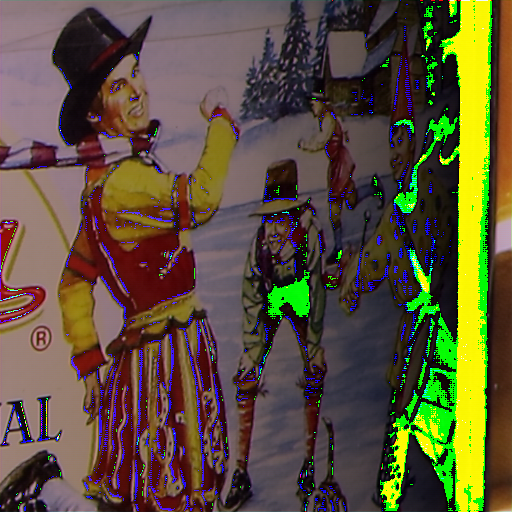

In [19]:
import torchvision.transforms as T
opimage = T.ToPILImage()(torch.squeeze(higan_denoised_imgs))
opimage

In [15]:
# fig, axes = plt.subplots(ncols=2)
# axes[0].imshow(im8)
# axes[0].axis('off')
# axes[0].set_title('Noisy')

# axes[1].imshow(higan_denoised_imgs)
# axes[1].axis('off')
# # myimshow( model.predict(xtest_noisy[3]), ax=axes[1])
# axes[1].set_title('Clean')


arr = np.ndarray(higan_denoised_imgs.detach())
arr_ = np.squeeze(arr)
myimshow(arr_)

TypeError: Tensor is not a sequence

In [ ]:
print("HiGAN")
plot_predictions(im8, higan_denoised_imgs)

: 